In [1]:
# Backprop will not magically work optimally if you don't understand how it works under the hood
# We will backprop by hand :muscle:

In [2]:
# Read through this
# # https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b
# When you clip the loss of an outlier you're setting its gradient to zero, and other subtle things like that

In [3]:
# Micrograd was only on individual scalars
# It's not enough, let's think about autograd on the level of multi dim. tensors
# Become better at debugging neural networks, making sure you understand what you're doing
# EMERGE STRONGER
# Nobody writes backward pass by hand, this is mostly for fun and exercise
# Pretty cool bit of history trivia : RBMs, Matlab, No backprop

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
import torch.nn.functional as F

In [6]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [7]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [9]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [10]:
# compare manual gradients to pytorch gradients
# def cmp(s, dt, t):
#     ex  = torch.all(dt == t.grad).item()
#     app = torch.allclose(dt, t.grad)
#     maxdiff = (dt - t.grad).abs().max().item()
#     print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
    
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


In [11]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 64 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1 # only for fun, is useless because of batchnorm

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0   # non standard init
bnbias = torch.zeros((1, n_hidden)) * 0.1         # non standard init

# non standard init to be small numbers, sometimes if the tensors are init to zero, it can mask an incorrect implementation

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

4137

In [12]:
batch_size = 32
bs = batch_size

In [13]:
# lets get a batch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [14]:
# forward pass - breaking down the forward pass into manageable chunks so we can inspect as needed

# embedding 
emb            = C[Xb]                                        # embed the characters into vectors
embcat         = emb.view(emb.shape[0], -1)             # concatenate the vectors
# Linear layer
hprebn         = embcat @ W1 + b1                       # hidden layer pre-activation
# Batchnorm layer ------------------------------
bnmeani        = 1/bs*hprebn.sum(0, keepdim=True)
bndiff         = hprebn - bnmeani
bndiff2        = bndiff**2
bnvar          = 1/(bs-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction : divinding by n-1, not n
bnvar_inv      = (bnvar + 1e-5)**-0.5
bnraw          = bndiff * bnvar_inv
hpreact        = bngain * bnraw + bnbias
# Non linearity
h              = torch.tanh(hpreact)                    # hidden layer
# Linear layer 2
logits         = h @ W2 + b2
# cross entropy loss (same as F.cross_entry(logits, Yb)
logit_maxes    = logits.max(1, keepdim=True).values
norm_logits    = logits - logit_maxes                  # substract max for numerical stability
counts         = norm_logits.exp()
counts_sum     = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs          = counts * counts_sum_inv
logprobs       = probs.log()
loss           = -logprobs[range(bs), Yb].mean()

# backward pass

# zero out grads
for p in parameters:
    p.grad = None

# Retain the grad
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits,
          h, hpreact, 
          bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
  t.retain_grad()

# backwara
loss.backward()
loss

tensor(3.3353, grad_fn=<NegBackward0>)

In [15]:
# WE will do a bunch of derivations for some equations such as cross entropy and batchnorm
# and implement the efficient version by hand
# We will also hand implement the rest of backward
# In the end we will train using this hand implement functions and arrive at the same loss
# This will be AWESOME

In [16]:
# Let's start implement backward pass
# 15 mins. in, this is going to be a great lecture, a bit intense even
# think I have to come back and listen to it with a fresh head again

In [17]:
# when considering multiplications/additions with broadcasting rules applied 
# you need to sum(accumulate gradients) across the broadcasted dimension

# the backward pass of a matrix multiply is a yet another matrix multiply with other element transposed
# For a forward pass x = a @ b + c
# dL/da = dL/dx @ aT
# dL/db = aT @ dL/dx
# dL/dc = dL/dx.sum(0)

# More tricks on shape matching thinking

# Tricky to take notes for this chapter, since it's mostly mathematical thinking

In [18]:
# Exercise 1: backprop through the whole thing manually
# backward through all of the variables one by one
# as defined in forward pass

# Also the talk about Bessels correction
# SCRUTINIZE YO' SHAPES

# When we have a sum in forward pass, that turns to be broadcasting/replication in the backward pass
# and conversely, when we have a broadcasting in backward pass, we have a sum in the forward pass

# holds the derivate of loss wrt all the elements of logprobs, same size as logprobs
dlogprobs                = torch.zeros_like(logprobs)
dlogprobs[range(bs), Yb] = -1.0/bs
dprobs                   = (1.0 / probs) * dlogprobs # d(probs.log())/d(probs) = 1/probs
dcounts_sum_inv          = (counts * dprobs).sum(dim=1, keepdim=True) # accumulate backward for the broadcasted term in forward pass
dcounts                  = counts_sum_inv * dprobs
dcounts_sum              = (-counts_sum**-2) * dcounts_sum_inv
dcounts                 += torch.ones_like(counts) * dcounts_sum
dnorm_logits             = counts * dcounts  # norm_logits.exp() already having been assigned to counts
dlogits                  = dnorm_logits.clone()
dlogit_maxes             = (-dnorm_logits).sum(1, keepdim=True)
dlogits                 += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh                       = dlogits @ W2.T
dW2                      = h.T @ dlogits
db2                      = dlogits.sum(0)
dhpreact                 = (1.0 - h**2.0) * dh                      # WHY NOT EXACT MATCH on my CPU ???
dbngain                  = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw                   = bngain * dhpreact # shapes already correct, matches with forward pass
dbnbias                  = dhpreact.sum(0, keepdim=True)
dbndiff                  = bnvar_inv * dbnraw
dbnvar_inv               = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar                   = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2                 = (1.0/(bs-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff                 += 2 * bndiff * dbndiff2
dhprebn                  = dbndiff.clone()
dbnmeani                 = (-dbndiff).sum(0)
dhprebn                 += 1/bs * (torch.ones_like(hprebn) * dbnmeani)
dembcat                  = dhprebn @ W1.T
dW1                      = embcat.T @ dhprebn
db1                      = dhprebn.sum(0)
demb                     = dembcat.view(emb.shape)

# Find where the gradient needs to flow back to in the embedding and accumulate them
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] 
#dC.index_add_(0, Xb.view(-1),  demb.view(-1, 10))

cmp('dlogprobs', dlogprobs, logprobs)
cmp('dprobs', dprobs, probs)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('dlogits', dlogits, logits)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dhprebn', dhprebn, hprebn)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

dlogprobs       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dbngain         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
dbnraw          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dbnbias 

In [19]:
# Too bad, the exact matches doesn't seem to work on this machine
# I'm assuming it has to do with some floating point arithmetic but not sure
# Even running Karpathy original nb gives me similar result on this machine

In [20]:
# Exercise 2 : backprop through cross_entropy but all in one go
# mathematical expression can be simplified analytically, backprop through less steps then

# Previously forward pass cross entroy
# cross entropy loss
# logit_maxes    = logits.max(1, keepdim=True).values
# norm_logits    = logits - logit_maxes                  # substract max for numerical stability
# counts         = norm_logits.exp()
# counts_sum     = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1
# probs          = counts * counts_sum_inv
# logprobs       = probs.log()
# loss           = -logprobs[range(bs), Yb].mean()

# now
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff :', (loss_fast - loss).item())

3.3353161811828613 diff : -2.384185791015625e-07


In [21]:
# backward pass with cross entropy loss
# done on pen and paper

dlogits = F.softmax(logits, 1)
dlogits[range(bs), Yb] -= 1
dlogits /= bs

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.402842700481415e-09


In [22]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [23]:
# index of the correct output for first row
Yb[0]

tensor(8)

In [24]:
# probs on the first row (first item in the batch)
F.softmax(logits, 1)[0], F.softmax(logits, 1)[0][Yb[0]]

(tensor([0.0687, 0.0888, 0.0184, 0.0504, 0.0196, 0.0814, 0.0246, 0.0364, 0.0190,
         0.0307, 0.0353, 0.0359, 0.0371, 0.0294, 0.0336, 0.0133, 0.0089, 0.0189,
         0.0153, 0.0552, 0.0497, 0.0228, 0.0258, 0.0729, 0.0600, 0.0273, 0.0205],
        grad_fn=<SelectBackward0>),
 tensor(0.0190, grad_fn=<SelectBackward0>))

In [25]:
# lets look at the gradients (on the item, so denormalize by multiplying with batch size)
dlogits[0] * bs, (dlogits[0] * bs)[Yb[0]]

(tensor([ 0.0687,  0.0888,  0.0184,  0.0504,  0.0196,  0.0814,  0.0246,  0.0364,
         -0.9810,  0.0307,  0.0353,  0.0359,  0.0371,  0.0294,  0.0336,  0.0133,
          0.0089,  0.0189,  0.0153,  0.0552,  0.0497,  0.0228,  0.0258,  0.0729,
          0.0600,  0.0273,  0.0205], grad_fn=<MulBackward0>),
 tensor(-0.9810, grad_fn=<SelectBackward0>))

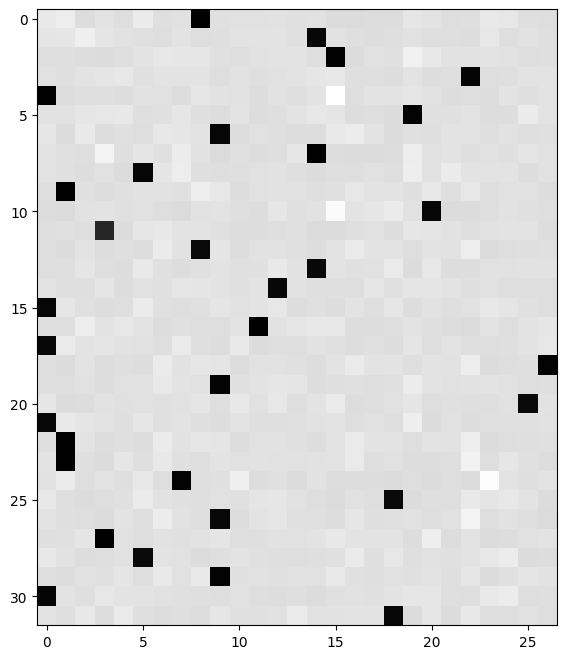

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray');

In [27]:
# what we want to do is
# pull down the probability of incorrect characters and
# pull up the probability of the correct characters
#
# cross entropy does this dynamically during training

In [28]:
# Exercise 3 : backprop through batchnorm but all in one go

# previously batch norm forward pass
# bnmeani        = 1/bs*hprebn.sum(0, keepdim=True)
# bndiff         = hprebn - bnmeani
# bndiff2        = bndiff**2
# bnvar          = 1/(bs-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction : divinding by n-1, not n
# bnvar_inv      = (bnvar + 1e-5)**-0.5
# bnraw          = bndiff * bnvar_inv
# hpreact        = bngain * bnraw + bnbias

# now
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True))
print('max diff :', (hpreact_fast - hpreact).abs().max())

max diff : tensor(2.6941e-05, grad_fn=<MaxBackward1>)


In [29]:
# backward pass
# done on pen and paper

# calculate dhprebn given dhpreact (backprop through the batchnorm above)
# not trivial at all tbh
dhprebn = bngain*bnvar_inv/bs * (bs*dhpreact - dhpreact.sum(0) - bs/(bs-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [30]:
# Exercise 4
# PUT THE MADNESS TOGETHER


In [31]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 64 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1 # only for fun, is useless because of batchnorm

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0   # non standard init
bnbias = torch.zeros((1, n_hidden)) * 0.1         # non standard init

# non standard init to be small numbers, sometimes if the tensors are init to zero, it can mask an incorrect implementation

bnmean_running = torch.zeros((1, n_hidden)) # the way we init W1 and b1, hpreact will be roughly unit gaussian, mean roughly zero
bnstd_running = torch.ones((1, n_hidden))   # std dev roughly one



parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

4137

In [32]:
max_steps = 200000
batch_size = 32
bs = batch_size

In [33]:
lossi = []
losslog10i = []
stepsi = []

In [34]:
tot_steps = len(stepsi)

with torch.no_grad():
    for i in range(max_steps):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

        # forward pass
        emb = C[Xb]                         # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hpreact = embcat @ W1 # + b1          # hidden layer pre-activation
        # Batchnorm layer ------------------------------
        bnmeani = hpreact.mean(dim=0, keepdim=True)  # bn mean for ith iter        <-----
        bnstdi  = hpreact.std(dim=0, keepdim=True)   # bn std  for ith iter        <----- 
        hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias     # normalize hpreact, also scale and shift
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
        # Batchnorm layer ------------------------------
        # Non linearity
        h = torch.tanh(hpreact)             # hidden layer
        logits = h @ W2 + b2                # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward()

        # manual backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(bs), Yb] -= 1
        dlogits /= bs
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/bs * (bs*dhpreact - dhpreact.sum(0) - bs/(bs-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
          for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]

        # gradients
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update
        lr = 0.1 if i < 100000 else 0.01    # switch learning rate
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad
            p.data += -lr * grad


        # track stats
        stepsi.append(tot_steps+i)
        lossi.append(loss.item())
        losslog10i.append(loss.log10().item())

        # Print loss 
        if (i)%(max_steps/10) == 0:
            print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3285608291625977
Loss 20000/200000: 2.0454561710357666
Loss 40000/200000: 2.2798118591308594
Loss 60000/200000: 2.241567850112915
Loss 80000/200000: 2.248002290725708
Loss 100000/200000: 2.2513630390167236
Loss 120000/200000: 1.9825865030288696
Loss 140000/200000: 2.05417537689209
Loss 160000/200000: 2.132864475250244
Loss 180000/200000: 1.9263790845870972


In [35]:
# can be used for comparing - before fully using backprop grads
# for p, g in zip(parameters, grads):
#    cmp(str(tuple(p.shape)), g, p)

In [36]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.178114414215088
val loss : 2.189039468765259


In [37]:
# Note our losses going down with tricks

# Train test validation split - in the beginning
# Train Loss : 2.2589
# Val Loss   : 2.2702

# After increasing NN capacity and embedding size
# Train Loss : 2.1190
# Val Loss   : 2.1711

# After fixing init weight bias softmax confidently wrong
# Train loss : 2.0695
# Val loss   : 2.1310

# After fixing tanh saturation
# train loss : 2.0355
# val loss   : 2.1026

# Now, with kaiming init and not using magic numbers for tanh saturation
# train loss : 2.0376
# val loss   : 2.1069

# With batch norm
# train loss : 2.0668
# val loss   : 2.1048

# With manual backprop
# train loss : 2.176852226257324
# val loss : 2.1903560161590576

In [38]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(40):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
mrix.
taty.
salanna.
jazhnen.
den.
rha.
kaqui.
nelynna.
chaiivon.
leigh.
ham.
jock.
quinn.
salin.
alianni.
watelo.
dearynix.
kaeliigsa.
med.
edi.
abetteley.
rey.
aras.
ben.
husya.
samboson.
kyloj.
mikaaseren.
kalla.
lulo.
zoe.
sikora.
krynn.
amonleyno.
adeneliah.
bris.
bria.


In [39]:
# CRAZY PART IS THAT
# EVERYTHING IS THE SAME
# NO Loss.backward - No Pytorch Autograd
# Sort of similar - batchnorm is the most complex thing really